<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:08:52] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


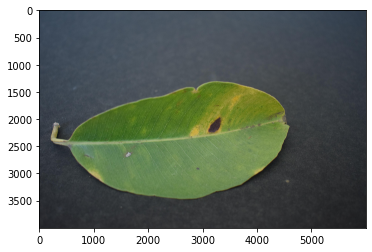

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

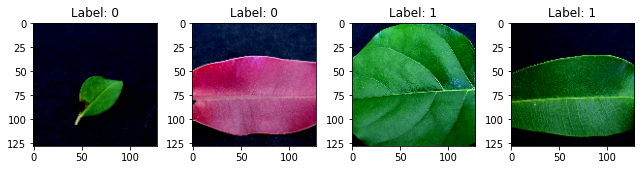

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:08:58] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:08:59] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2248176084117903 samples/sec                   batch loss = 0.5712007284164429 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2664301667526694 samples/sec                   batch loss = 0.5380170345306396 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2634966165356343 samples/sec                   batch loss = 0.5339059829711914 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2688445608660917 samples/sec                   batch loss = 0.7882871627807617 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2604824857773997 samples/sec                   batch loss = 1.6190742254257202 | accuracy = 0.47


Epoch[1] Batch[30] Speed: 1.265970322783943 samples/sec                   batch loss = 0.6212971210479736 | accuracy = 0.49166666666666664


Epoch[1] Batch[35] Speed: 1.264684877633118 samples/sec                   batch loss = 0.5938947796821594 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.2640286576779165 samples/sec                   batch loss = 0.6026226878166199 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.263031768713306 samples/sec                   batch loss = 0.6522685885429382 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.263449802370589 samples/sec                   batch loss = 1.225454568862915 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2680015239705282 samples/sec                   batch loss = 0.6253656148910522 | accuracy = 0.5545454545454546


Epoch[1] Batch[60] Speed: 1.2679440261726518 samples/sec                   batch loss = 0.514129638671875 | accuracy = 0.5666666666666667


Epoch[1] Batch[65] Speed: 1.2617353906392126 samples/sec                   batch loss = 0.5371299982070923 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.2621899786249746 samples/sec                   batch loss = 0.536500096321106 | accuracy = 0.5642857142857143


Epoch[1] Batch[75] Speed: 1.272904397059118 samples/sec                   batch loss = 0.5755285024642944 | accuracy = 0.56


Epoch[1] Batch[80] Speed: 1.2697346518060355 samples/sec                   batch loss = 0.3480566442012787 | accuracy = 0.565625


Epoch[1] Batch[85] Speed: 1.2695149179135277 samples/sec                   batch loss = 0.6430628895759583 | accuracy = 0.5647058823529412


Epoch[1] Batch[90] Speed: 1.2639702816740757 samples/sec                   batch loss = 0.6634637117385864 | accuracy = 0.5666666666666667


Epoch[1] Batch[95] Speed: 1.2671598937010267 samples/sec                   batch loss = 1.1306170225143433 | accuracy = 0.5684210526315789


Epoch[1] Batch[100] Speed: 1.267750296984649 samples/sec                   batch loss = 0.5965913534164429 | accuracy = 0.5725


Epoch[1] Batch[105] Speed: 1.2714702112468608 samples/sec                   batch loss = 0.8784875869750977 | accuracy = 0.5714285714285714


Epoch[1] Batch[110] Speed: 1.2646210075289848 samples/sec                   batch loss = 0.3384612202644348 | accuracy = 0.575


Epoch[1] Batch[115] Speed: 1.2639384771157531 samples/sec                   batch loss = 0.4636507034301758 | accuracy = 0.5804347826086956


Epoch[1] Batch[120] Speed: 1.2716192961669854 samples/sec                   batch loss = 0.7889165878295898 | accuracy = 0.5833333333333334


Epoch[1] Batch[125] Speed: 1.2803759893175417 samples/sec                   batch loss = 0.3016505241394043 | accuracy = 0.588


Epoch[1] Batch[130] Speed: 1.2700018553582118 samples/sec                   batch loss = 0.6608947515487671 | accuracy = 0.5865384615384616


Epoch[1] Batch[135] Speed: 1.2653740362649404 samples/sec                   batch loss = 0.5001161694526672 | accuracy = 0.5888888888888889


Epoch[1] Batch[140] Speed: 1.27334774119732 samples/sec                   batch loss = 0.4420143961906433 | accuracy = 0.5928571428571429


Epoch[1] Batch[145] Speed: 1.2646571362431356 samples/sec                   batch loss = 0.4914115071296692 | accuracy = 0.5948275862068966


Epoch[1] Batch[150] Speed: 1.2612592267438543 samples/sec                   batch loss = 0.6088988780975342 | accuracy = 0.6033333333333334


Epoch[1] Batch[155] Speed: 1.2608556227296794 samples/sec                   batch loss = 0.3769644796848297 | accuracy = 0.603225806451613


Epoch[1] Batch[160] Speed: 1.2626704568118376 samples/sec                   batch loss = 0.39705801010131836 | accuracy = 0.603125


Epoch[1] Batch[165] Speed: 1.2654196569178238 samples/sec                   batch loss = 0.2135598510503769 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.2615717280430168 samples/sec                   batch loss = 0.21939893066883087 | accuracy = 0.6132352941176471


Epoch[1] Batch[175] Speed: 1.2634694030012603 samples/sec                   batch loss = 0.3559522330760956 | accuracy = 0.6142857142857143


Epoch[1] Batch[180] Speed: 1.2609230932494622 samples/sec                   batch loss = 0.5566169023513794 | accuracy = 0.6180555555555556


Epoch[1] Batch[185] Speed: 1.25759100476832 samples/sec                   batch loss = 1.0093889236450195 | accuracy = 0.6162162162162163


Epoch[1] Batch[190] Speed: 1.2646326371272427 samples/sec                   batch loss = 0.49458998441696167 | accuracy = 0.6210526315789474


Epoch[1] Batch[195] Speed: 1.2674998398363793 samples/sec                   batch loss = 0.49906858801841736 | accuracy = 0.6205128205128205


Epoch[1] Batch[200] Speed: 1.2667330893272033 samples/sec                   batch loss = 0.36872777342796326 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.2642826989243374 samples/sec                   batch loss = 0.2444763034582138 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.267111659293718 samples/sec                   batch loss = 0.2587329149246216 | accuracy = 0.6309523809523809


Epoch[1] Batch[215] Speed: 1.2691784027152517 samples/sec                   batch loss = 0.21067968010902405 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.2745378615752863 samples/sec                   batch loss = 0.3468278646469116 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.2644378219180168 samples/sec                   batch loss = 0.5060700178146362 | accuracy = 0.6333333333333333


Epoch[1] Batch[230] Speed: 1.2580922327133963 samples/sec                   batch loss = 0.6730091571807861 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.2695109793465928 samples/sec                   batch loss = 0.7236620783805847 | accuracy = 0.6308510638297873


Epoch[1] Batch[240] Speed: 1.2695533442390776 samples/sec                   batch loss = 0.8079415559768677 | accuracy = 0.6302083333333334


Epoch[1] Batch[245] Speed: 1.271502492346225 samples/sec                   batch loss = 0.3107592761516571 | accuracy = 0.6346938775510204


Epoch[1] Batch[250] Speed: 1.2672253605563604 samples/sec                   batch loss = 1.7195570468902588 | accuracy = 0.636


Epoch[1] Batch[255] Speed: 1.2584923700053454 samples/sec                   batch loss = 0.3875340223312378 | accuracy = 0.6372549019607843


Epoch[1] Batch[260] Speed: 1.2662504705829432 samples/sec                   batch loss = 0.801385760307312 | accuracy = 0.6346153846153846


Epoch[1] Batch[265] Speed: 1.2676862126750668 samples/sec                   batch loss = 0.4663766622543335 | accuracy = 0.6358490566037736


Epoch[1] Batch[270] Speed: 1.267691672520702 samples/sec                   batch loss = 0.3371196389198303 | accuracy = 0.637962962962963


Epoch[1] Batch[275] Speed: 1.2633850104389637 samples/sec                   batch loss = 0.3141484558582306 | accuracy = 0.6372727272727273


Epoch[1] Batch[280] Speed: 1.2666174682547562 samples/sec                   batch loss = 0.7833743691444397 | accuracy = 0.6348214285714285


Epoch[1] Batch[285] Speed: 1.273149652159231 samples/sec                   batch loss = 0.7644252777099609 | accuracy = 0.6359649122807017


Epoch[1] Batch[290] Speed: 1.2746743988472236 samples/sec                   batch loss = 0.5389130115509033 | accuracy = 0.6336206896551724


Epoch[1] Batch[295] Speed: 1.2650004143224522 samples/sec                   batch loss = 0.738959550857544 | accuracy = 0.6364406779661017


Epoch[1] Batch[300] Speed: 1.2679888740075755 samples/sec                   batch loss = 0.7332046031951904 | accuracy = 0.6391666666666667


Epoch[1] Batch[305] Speed: 1.2645387485275064 samples/sec                   batch loss = 0.5434052348136902 | accuracy = 0.6426229508196721


Epoch[1] Batch[310] Speed: 1.2696488437316011 samples/sec                   batch loss = 0.6406584978103638 | accuracy = 0.6459677419354839


Epoch[1] Batch[315] Speed: 1.2647928041701968 samples/sec                   batch loss = 0.5693018436431885 | accuracy = 0.6476190476190476


Epoch[1] Batch[320] Speed: 1.265476544180946 samples/sec                   batch loss = 0.5026889443397522 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.2699946451532127 samples/sec                   batch loss = 0.574367105960846 | accuracy = 0.6530769230769231


Epoch[1] Batch[330] Speed: 1.265283663638733 samples/sec                   batch loss = 0.5160428285598755 | accuracy = 0.6515151515151515


Epoch[1] Batch[335] Speed: 1.2702628237388978 samples/sec                   batch loss = 0.4674748182296753 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2683306075071927 samples/sec                   batch loss = 1.2361030578613281 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2666810620142515 samples/sec                   batch loss = 0.6009888648986816 | accuracy = 0.6565217391304348


Epoch[1] Batch[350] Speed: 1.2626923140606585 samples/sec                   batch loss = 0.32980960607528687 | accuracy = 0.6578571428571428


Epoch[1] Batch[355] Speed: 1.26815554792957 samples/sec                   batch loss = 0.40720611810684204 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2686999633921592 samples/sec                   batch loss = 0.32868245244026184 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.2579127255087126 samples/sec                   batch loss = 0.2991463541984558 | accuracy = 0.6582191780821918


Epoch[1] Batch[370] Speed: 1.2631990440860352 samples/sec                   batch loss = 0.1793670952320099 | accuracy = 0.6601351351351351


Epoch[1] Batch[375] Speed: 1.2667165434131173 samples/sec                   batch loss = 0.44860437512397766 | accuracy = 0.662


Epoch[1] Batch[380] Speed: 1.2663254015098795 samples/sec                   batch loss = 0.3727712035179138 | accuracy = 0.6625


Epoch[1] Batch[385] Speed: 1.268448267793147 samples/sec                   batch loss = 0.24481593072414398 | accuracy = 0.6649350649350649


Epoch[1] Batch[390] Speed: 1.2706721850357234 samples/sec                   batch loss = 0.29410672187805176 | accuracy = 0.6666666666666666


Epoch[1] Batch[395] Speed: 1.2588248473234016 samples/sec                   batch loss = 0.4936908483505249 | accuracy = 0.6658227848101266


Epoch[1] Batch[400] Speed: 1.26211287779396 samples/sec                   batch loss = 0.5751551389694214 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.266188735691693 samples/sec                   batch loss = 0.43639057874679565 | accuracy = 0.6654320987654321


Epoch[1] Batch[410] Speed: 1.2720265426070712 samples/sec                   batch loss = 0.383161723613739 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.2734427491739466 samples/sec                   batch loss = 0.8135775327682495 | accuracy = 0.6668674698795181


Epoch[1] Batch[420] Speed: 1.2596338752384635 samples/sec                   batch loss = 0.5672093033790588 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2719250922564056 samples/sec                   batch loss = 0.6794789433479309 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2727823360083899 samples/sec                   batch loss = 0.4506124258041382 | accuracy = 0.6674418604651163


Epoch[1] Batch[435] Speed: 1.2732046277664164 samples/sec                   batch loss = 0.6666903495788574 | accuracy = 0.667816091954023


Epoch[1] Batch[440] Speed: 1.2653544719300371 samples/sec                   batch loss = 1.1605714559555054 | accuracy = 0.6676136363636364


Epoch[1] Batch[445] Speed: 1.2692941077049935 samples/sec                   batch loss = 0.42000752687454224 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.2761936768030349 samples/sec                   batch loss = 0.1992807537317276 | accuracy = 0.67


Epoch[1] Batch[455] Speed: 1.2715174289319429 samples/sec                   batch loss = 0.7484570741653442 | accuracy = 0.6681318681318681


Epoch[1] Batch[460] Speed: 1.2685432174339162 samples/sec                   batch loss = 0.7362673282623291 | accuracy = 0.6695652173913044


Epoch[1] Batch[465] Speed: 1.2662283944118211 samples/sec                   batch loss = 0.6919853091239929 | accuracy = 0.6698924731182796


Epoch[1] Batch[470] Speed: 1.2718077502027991 samples/sec                   batch loss = 0.716147243976593 | accuracy = 0.6696808510638298


Epoch[1] Batch[475] Speed: 1.2753335782562567 samples/sec                   batch loss = 0.5180182456970215 | accuracy = 0.6710526315789473


Epoch[1] Batch[480] Speed: 1.2682232267894402 samples/sec                   batch loss = 0.34312671422958374 | accuracy = 0.671875


Epoch[1] Batch[485] Speed: 1.2719819873232558 samples/sec                   batch loss = 0.4518669843673706 | accuracy = 0.6742268041237114


Epoch[1] Batch[490] Speed: 1.2636339390669205 samples/sec                   batch loss = 0.2688532769680023 | accuracy = 0.6760204081632653


Epoch[1] Batch[495] Speed: 1.2699071678550873 samples/sec                   batch loss = 0.38617268204689026 | accuracy = 0.6772727272727272


Epoch[1] Batch[500] Speed: 1.2723841587519404 samples/sec                   batch loss = 0.569892168045044 | accuracy = 0.679


Epoch[1] Batch[505] Speed: 1.2676707912598408 samples/sec                   batch loss = 0.3215485215187073 | accuracy = 0.6797029702970298


Epoch[1] Batch[510] Speed: 1.2651938763806043 samples/sec                   batch loss = 0.8191297054290771 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2690550393060098 samples/sec                   batch loss = 1.8490216732025146 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.269910628266513 samples/sec                   batch loss = 0.8572988510131836 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2665075091521862 samples/sec                   batch loss = 0.6740996241569519 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2656079962281943 samples/sec                   batch loss = 0.2664220929145813 | accuracy = 0.6783018867924528


Epoch[1] Batch[535] Speed: 1.2637906164623012 samples/sec                   batch loss = 1.146622657775879 | accuracy = 0.6785046728971963


Epoch[1] Batch[540] Speed: 1.263486720569317 samples/sec                   batch loss = 0.44788384437561035 | accuracy = 0.6791666666666667


Epoch[1] Batch[545] Speed: 1.2624831807153267 samples/sec                   batch loss = 0.45931190252304077 | accuracy = 0.6788990825688074


Epoch[1] Batch[550] Speed: 1.2702784044624305 samples/sec                   batch loss = 0.7826235890388489 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.268939185944053 samples/sec                   batch loss = 0.5552537441253662 | accuracy = 0.6783783783783783


Epoch[1] Batch[560] Speed: 1.259170636251624 samples/sec                   batch loss = 0.684609591960907 | accuracy = 0.6785714285714286


Epoch[1] Batch[565] Speed: 1.265803267717679 samples/sec                   batch loss = 0.17202159762382507 | accuracy = 0.679646017699115


Epoch[1] Batch[570] Speed: 1.265875566871353 samples/sec                   batch loss = 0.5009487867355347 | accuracy = 0.6789473684210526


Epoch[1] Batch[575] Speed: 1.2685265282856149 samples/sec                   batch loss = 0.5488448739051819 | accuracy = 0.68


Epoch[1] Batch[580] Speed: 1.2647261583116436 samples/sec                   batch loss = 0.17415452003479004 | accuracy = 0.6814655172413793


Epoch[1] Batch[585] Speed: 1.2601457249597803 samples/sec                   batch loss = 0.4160595238208771 | accuracy = 0.6820512820512821


Epoch[1] Batch[590] Speed: 1.2717668735866965 samples/sec                   batch loss = 0.44651561975479126 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.2763574655642018 samples/sec                   batch loss = 0.318611204624176 | accuracy = 0.6865546218487395


Epoch[1] Batch[600] Speed: 1.2689279568753085 samples/sec                   batch loss = 0.5535150170326233 | accuracy = 0.6875


Epoch[1] Batch[605] Speed: 1.2662636593122127 samples/sec                   batch loss = 0.2906210124492645 | accuracy = 0.6871900826446281


Epoch[1] Batch[610] Speed: 1.2614347584898948 samples/sec                   batch loss = 0.92333984375 | accuracy = 0.6877049180327869


Epoch[1] Batch[615] Speed: 1.2723296399316317 samples/sec                   batch loss = 0.47986772656440735 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2635441002995729 samples/sec                   batch loss = 0.9420148730278015 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.2729618626992834 samples/sec                   batch loss = 0.372496098279953 | accuracy = 0.69


Epoch[1] Batch[630] Speed: 1.2625130119491326 samples/sec                   batch loss = 0.2931167483329773 | accuracy = 0.6912698412698413


Epoch[1] Batch[635] Speed: 1.26307294154209 samples/sec                   batch loss = 0.5053326487541199 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2664768196283036 samples/sec                   batch loss = 0.5805597305297852 | accuracy = 0.69140625


Epoch[1] Batch[645] Speed: 1.273025998548449 samples/sec                   batch loss = 1.2961397171020508 | accuracy = 0.6906976744186046


Epoch[1] Batch[650] Speed: 1.2680881638339443 samples/sec                   batch loss = 0.7104950547218323 | accuracy = 0.6911538461538461


Epoch[1] Batch[655] Speed: 1.2605985996768485 samples/sec                   batch loss = 0.31616532802581787 | accuracy = 0.6908396946564885


Epoch[1] Batch[660] Speed: 1.2649935469345621 samples/sec                   batch loss = 0.2591358721256256 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.2719667505181964 samples/sec                   batch loss = 0.7530325651168823 | accuracy = 0.6913533834586466


Epoch[1] Batch[670] Speed: 1.265470626140046 samples/sec                   batch loss = 0.33800143003463745 | accuracy = 0.6917910447761194


Epoch[1] Batch[675] Speed: 1.2685563580493353 samples/sec                   batch loss = 0.6808278560638428 | accuracy = 0.6925925925925925


Epoch[1] Batch[680] Speed: 1.2634460916400436 samples/sec                   batch loss = 0.3308909237384796 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.2737217660205442 samples/sec                   batch loss = 0.4199052155017853 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.2694687133373461 samples/sec                   batch loss = 0.663864254951477 | accuracy = 0.6905797101449276


Epoch[1] Batch[695] Speed: 1.274452468024394 samples/sec                   batch loss = 0.9838797450065613 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.2621604475138875 samples/sec                   batch loss = 0.44296807050704956 | accuracy = 0.6892857142857143


Epoch[1] Batch[705] Speed: 1.265112878407304 samples/sec                   batch loss = 1.3264424800872803 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.270533521031917 samples/sec                   batch loss = 0.4908568859100342 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2693389550623329 samples/sec                   batch loss = 0.36924120783805847 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.2672948547071237 samples/sec                   batch loss = 0.4759005606174469 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.2628635870464398 samples/sec                   batch loss = 0.7196512818336487 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.264846965062266 samples/sec                   batch loss = 0.6118443012237549 | accuracy = 0.6904109589041096


Epoch[1] Batch[735] Speed: 1.2681852643864269 samples/sec                   batch loss = 0.3091539144515991 | accuracy = 0.6908163265306122


Epoch[1] Batch[740] Speed: 1.2657960096062548 samples/sec                   batch loss = 0.5952915549278259 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2691991416429793 samples/sec                   batch loss = 0.4851626753807068 | accuracy = 0.6899328859060403


Epoch[1] Batch[750] Speed: 1.2706400423152449 samples/sec                   batch loss = 0.4519829750061035 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.269310528960592 samples/sec                   batch loss = 0.30541443824768066 | accuracy = 0.6897350993377483


Epoch[1] Batch[760] Speed: 1.2714898687957878 samples/sec                   batch loss = 0.412060022354126 | accuracy = 0.6907894736842105


Epoch[1] Batch[765] Speed: 1.2701744440285536 samples/sec                   batch loss = 0.13482297956943512 | accuracy = 0.6908496732026144


Epoch[1] Batch[770] Speed: 1.27002358260433 samples/sec                   batch loss = 0.7917559742927551 | accuracy = 0.6918831168831169


Epoch[1] Batch[775] Speed: 1.2635200249191227 samples/sec                   batch loss = 0.3406839370727539 | accuracy = 0.6919354838709677


Epoch[1] Batch[780] Speed: 1.2689941824585464 samples/sec                   batch loss = 0.6316874027252197 | accuracy = 0.6913461538461538


Epoch[1] Batch[785] Speed: 1.2663277910348287 samples/sec                   batch loss = 0.7489360570907593 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6928934010152284
[Epoch 1] time cost: 649.5387434959412
[Epoch 1] validation: validation accuracy=0.7388888888888889


Epoch[2] Batch[5] Speed: 1.2661177384531919 samples/sec                   batch loss = 0.22446796298027039 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2729252579353276 samples/sec                   batch loss = 0.550957977771759 | accuracy = 0.575


Epoch[2] Batch[15] Speed: 1.2691982775074588 samples/sec                   batch loss = 0.8100122213363647 | accuracy = 0.6


Epoch[2] Batch[20] Speed: 1.2691273263945886 samples/sec                   batch loss = 0.4754328727722168 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.267235602328354 samples/sec                   batch loss = 0.11558050662279129 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.271412976551118 samples/sec                   batch loss = 0.702180027961731 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2736900490080043 samples/sec                   batch loss = 0.9575504660606384 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2724777683316315 samples/sec                   batch loss = 0.4846579134464264 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.273342232522641 samples/sec                   batch loss = 0.5787374377250671 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2672980137132615 samples/sec                   batch loss = 1.0074656009674072 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2676270194730148 samples/sec                   batch loss = 0.4681093990802765 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2679614666203636 samples/sec                   batch loss = 0.48118823766708374 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.272340253848975 samples/sec                   batch loss = 0.3594617247581482 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2750000759959266 samples/sec                   batch loss = 0.3897481858730316 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2659933452634144 samples/sec                   batch loss = 0.49631616473197937 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.2670752945098365 samples/sec                   batch loss = 0.5416134595870972 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2688210507385 samples/sec                   batch loss = 0.48583537340164185 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2690089641844853 samples/sec                   batch loss = 0.4493003785610199 | accuracy = 0.7166666666666667


Epoch[2] Batch[95] Speed: 1.2676540292775424 samples/sec                   batch loss = 0.8627521991729736 | accuracy = 0.7105263157894737


Epoch[2] Batch[100] Speed: 1.268376058037456 samples/sec                   batch loss = 0.32552194595336914 | accuracy = 0.72


Epoch[2] Batch[105] Speed: 1.2722895981104503 samples/sec                   batch loss = 0.6692911982536316 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.2711003964703307 samples/sec                   batch loss = 0.6214709877967834 | accuracy = 0.7227272727272728


Epoch[2] Batch[115] Speed: 1.273742460288779 samples/sec                   batch loss = 0.2879787087440491 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.2714295490306469 samples/sec                   batch loss = 0.5505765080451965 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2620149011673845 samples/sec                   batch loss = 0.5670241117477417 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.267251013157049 samples/sec                   batch loss = 0.30890244245529175 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2661372308455343 samples/sec                   batch loss = 0.740812361240387 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2688375557165437 samples/sec                   batch loss = 0.1864888072013855 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.26394409516984 samples/sec                   batch loss = 0.6939212083816528 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2628753744655412 samples/sec                   batch loss = 0.6322630643844604 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2690347850383958 samples/sec                   batch loss = 0.13573965430259705 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.265609905682083 samples/sec                   batch loss = 0.3163487911224365 | accuracy = 0.734375


Epoch[2] Batch[165] Speed: 1.2652816597458052 samples/sec                   batch loss = 0.3301486372947693 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.2600161621259505 samples/sec                   batch loss = 0.26332753896713257 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2685097436655852 samples/sec                   batch loss = 0.563275933265686 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.2742439699574857 samples/sec                   batch loss = 0.16458140313625336 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2742942007182347 samples/sec                   batch loss = 0.5264952778816223 | accuracy = 0.7297297297297297


Epoch[2] Batch[190] Speed: 1.2670821845191391 samples/sec                   batch loss = 0.23375524580478668 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.265206375224747 samples/sec                   batch loss = 0.23778136074543 | accuracy = 0.7294871794871794


Epoch[2] Batch[200] Speed: 1.271473680181916 samples/sec                   batch loss = 0.2543843686580658 | accuracy = 0.73125


Epoch[2] Batch[205] Speed: 1.2723174823893568 samples/sec                   batch loss = 0.4471035301685333 | accuracy = 0.7280487804878049


Epoch[2] Batch[210] Speed: 1.2669251683296496 samples/sec                   batch loss = 0.3759858012199402 | accuracy = 0.7321428571428571


Epoch[2] Batch[215] Speed: 1.2642364933513712 samples/sec                   batch loss = 0.3744761049747467 | accuracy = 0.7302325581395349


Epoch[2] Batch[220] Speed: 1.2618003930731758 samples/sec                   batch loss = 0.4330853521823883 | accuracy = 0.7284090909090909


Epoch[2] Batch[225] Speed: 1.269831139685455 samples/sec                   batch loss = 0.26968130469322205 | accuracy = 0.7277777777777777


Epoch[2] Batch[230] Speed: 1.262494771027243 samples/sec                   batch loss = 0.45271727442741394 | accuracy = 0.7282608695652174


Epoch[2] Batch[235] Speed: 1.2639896127715176 samples/sec                   batch loss = 0.2721005380153656 | accuracy = 0.7276595744680852


Epoch[2] Batch[240] Speed: 1.2604364628597873 samples/sec                   batch loss = 0.6963230967521667 | accuracy = 0.7260416666666667


Epoch[2] Batch[245] Speed: 1.2651443604863184 samples/sec                   batch loss = 0.48592743277549744 | accuracy = 0.726530612244898


Epoch[2] Batch[250] Speed: 1.2664153494478592 samples/sec                   batch loss = 0.3908241391181946 | accuracy = 0.727


Epoch[2] Batch[255] Speed: 1.2683957159214236 samples/sec                   batch loss = 0.25581586360931396 | accuracy = 0.7294117647058823


Epoch[2] Batch[260] Speed: 1.269767517544507 samples/sec                   batch loss = 1.3278307914733887 | accuracy = 0.7298076923076923


Epoch[2] Batch[265] Speed: 1.2671293639571328 samples/sec                   batch loss = 0.42316779494285583 | accuracy = 0.7311320754716981


Epoch[2] Batch[270] Speed: 1.2754739708056533 samples/sec                   batch loss = 0.328431099653244 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.2750996916452366 samples/sec                   batch loss = 0.6907795071601868 | accuracy = 0.7354545454545455


Epoch[2] Batch[280] Speed: 1.2702452237516824 samples/sec                   batch loss = 0.5335785150527954 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2727855224312568 samples/sec                   batch loss = 0.21374227106571198 | accuracy = 0.7394736842105263


Epoch[2] Batch[290] Speed: 1.267743687092515 samples/sec                   batch loss = 0.3979954719543457 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.2682708747388294 samples/sec                   batch loss = 0.41712048649787903 | accuracy = 0.7398305084745763


Epoch[2] Batch[300] Speed: 1.2689143286998679 samples/sec                   batch loss = 0.6192830204963684 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.268250645494 samples/sec                   batch loss = 0.4847413897514343 | accuracy = 0.739344262295082


Epoch[2] Batch[310] Speed: 1.268884290163789 samples/sec                   batch loss = 0.05910034850239754 | accuracy = 0.7403225806451613


Epoch[2] Batch[315] Speed: 1.2605227349106807 samples/sec                   batch loss = 0.7470754981040955 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.2632781801077022 samples/sec                   batch loss = 0.5455740690231323 | accuracy = 0.73828125


Epoch[2] Batch[325] Speed: 1.275759602140286 samples/sec                   batch loss = 0.5711777210235596 | accuracy = 0.7384615384615385


Epoch[2] Batch[330] Speed: 1.2738768927006587 samples/sec                   batch loss = 0.10638265311717987 | accuracy = 0.7401515151515151


Epoch[2] Batch[335] Speed: 1.2684237174716861 samples/sec                   batch loss = 0.9561635255813599 | accuracy = 0.7380597014925373


Epoch[2] Batch[340] Speed: 1.2686414429281656 samples/sec                   batch loss = 0.6040182113647461 | accuracy = 0.7382352941176471


Epoch[2] Batch[345] Speed: 1.2748367322716239 samples/sec                   batch loss = 0.20762932300567627 | accuracy = 0.7391304347826086


Epoch[2] Batch[350] Speed: 1.274852037913309 samples/sec                   batch loss = 0.45353055000305176 | accuracy = 0.7407142857142858


Epoch[2] Batch[355] Speed: 1.2714178904389424 samples/sec                   batch loss = 0.38683706521987915 | accuracy = 0.7415492957746479


Epoch[2] Batch[360] Speed: 1.2714004511265091 samples/sec                   batch loss = 0.6727902889251709 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.2726676354098807 samples/sec                   batch loss = 0.584590494632721 | accuracy = 0.7410958904109589


Epoch[2] Batch[370] Speed: 1.2732478193151264 samples/sec                   batch loss = 0.3292998671531677 | accuracy = 0.7418918918918919


Epoch[2] Batch[375] Speed: 1.2644584062075162 samples/sec                   batch loss = 1.8176699876785278 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2611900137167777 samples/sec                   batch loss = 0.28860360383987427 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.2573926986123891 samples/sec                   batch loss = 0.6993188858032227 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2657714663460922 samples/sec                   batch loss = 0.3270627558231354 | accuracy = 0.7410256410256411


Epoch[2] Batch[395] Speed: 1.2698401741619727 samples/sec                   batch loss = 0.4184739291667938 | accuracy = 0.740506329113924


Epoch[2] Batch[400] Speed: 1.26892498168527 samples/sec                   batch loss = 0.23931275308132172 | accuracy = 0.741875


Epoch[2] Batch[405] Speed: 1.2652976910669564 samples/sec                   batch loss = 0.5993967652320862 | accuracy = 0.7419753086419754


Epoch[2] Batch[410] Speed: 1.264595461293641 samples/sec                   batch loss = 0.2769450843334198 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.2707678529336734 samples/sec                   batch loss = 0.22465239465236664 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.2639867559218527 samples/sec                   batch loss = 0.8897417187690735 | accuracy = 0.743452380952381


Epoch[2] Batch[425] Speed: 1.2717276383631255 samples/sec                   batch loss = 0.18540547788143158 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.268153822500661 samples/sec                   batch loss = 0.9414647221565247 | accuracy = 0.7412790697674418


Epoch[2] Batch[435] Speed: 1.265982263799478 samples/sec                   batch loss = 0.7029215693473816 | accuracy = 0.7408045977011494


Epoch[2] Batch[440] Speed: 1.2698241236381185 samples/sec                   batch loss = 0.3513607382774353 | accuracy = 0.7414772727272727


Epoch[2] Batch[445] Speed: 1.2727658247999745 samples/sec                   batch loss = 0.5071635246276855 | accuracy = 0.7410112359550561


Epoch[2] Batch[450] Speed: 1.26746661261538 samples/sec                   batch loss = 0.719234824180603 | accuracy = 0.7416666666666667


Epoch[2] Batch[455] Speed: 1.2644244806068556 samples/sec                   batch loss = 0.6425309777259827 | accuracy = 0.7428571428571429


Epoch[2] Batch[460] Speed: 1.2710820991638863 samples/sec                   batch loss = 0.9132531881332397 | accuracy = 0.7429347826086956


Epoch[2] Batch[465] Speed: 1.2798080366058375 samples/sec                   batch loss = 0.25666970014572144 | accuracy = 0.7440860215053764


Epoch[2] Batch[470] Speed: 1.2745670064379353 samples/sec                   batch loss = 0.27553796768188477 | accuracy = 0.7436170212765958


Epoch[2] Batch[475] Speed: 1.2684165251746857 samples/sec                   batch loss = 0.44513431191444397 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.268232909483262 samples/sec                   batch loss = 0.931264340877533 | accuracy = 0.7453125


Epoch[2] Batch[485] Speed: 1.2710237439057632 samples/sec                   batch loss = 0.3828093707561493 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.274190839994389 samples/sec                   batch loss = 0.8531235456466675 | accuracy = 0.7433673469387755


Epoch[2] Batch[495] Speed: 1.2710311583856255 samples/sec                   batch loss = 0.5126190185546875 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2624328318305658 samples/sec                   batch loss = 0.38858652114868164 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2668261561914549 samples/sec                   batch loss = 0.7221291661262512 | accuracy = 0.745049504950495


Epoch[2] Batch[510] Speed: 1.27664106416787 samples/sec                   batch loss = 0.5760189890861511 | accuracy = 0.746078431372549


Epoch[2] Batch[515] Speed: 1.2695901396258749 samples/sec                   batch loss = 0.2904573082923889 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2758989241276932 samples/sec                   batch loss = 0.4965166449546814 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.2636091940639076 samples/sec                   batch loss = 0.21286410093307495 | accuracy = 0.7480952380952381


Epoch[2] Batch[530] Speed: 1.2642445909912072 samples/sec                   batch loss = 0.31678980588912964 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.2738287258839698 samples/sec                   batch loss = 0.32937517762184143 | accuracy = 0.7490654205607477


Epoch[2] Batch[540] Speed: 1.2673587079800495 samples/sec                   batch loss = 0.1678091138601303 | accuracy = 0.750462962962963


Epoch[2] Batch[545] Speed: 1.2714964214471711 samples/sec                   batch loss = 0.5835257172584534 | accuracy = 0.75


Epoch[2] Batch[550] Speed: 1.2641882907244497 samples/sec                   batch loss = 0.7751978635787964 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.269773283638966 samples/sec                   batch loss = 0.22813978791236877 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2728535032533328 samples/sec                   batch loss = 0.14763346314430237 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2660003190427631 samples/sec                   batch loss = 0.3418402373790741 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2689636602440248 samples/sec                   batch loss = 0.5857275128364563 | accuracy = 0.7491228070175439


Epoch[2] Batch[575] Speed: 1.265639598431463 samples/sec                   batch loss = 0.47156330943107605 | accuracy = 0.75


Epoch[2] Batch[580] Speed: 1.2721260799701068 samples/sec                   batch loss = 0.6969900131225586 | accuracy = 0.75


Epoch[2] Batch[585] Speed: 1.2724447621449333 samples/sec                   batch loss = 0.19694992899894714 | accuracy = 0.75


Epoch[2] Batch[590] Speed: 1.2708121306799502 samples/sec                   batch loss = 0.4192463159561157 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.2657231465998906 samples/sec                   batch loss = 0.14003786444664001 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.2676670556939709 samples/sec                   batch loss = 0.6822101473808289 | accuracy = 0.7516666666666667


Epoch[2] Batch[605] Speed: 1.2662492281805773 samples/sec                   batch loss = 0.5747851729393005 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.270636674160224 samples/sec                   batch loss = 0.31646040081977844 | accuracy = 0.7516393442622951


Epoch[2] Batch[615] Speed: 1.2720541260136988 samples/sec                   batch loss = 0.24554063379764557 | accuracy = 0.7520325203252033


Epoch[2] Batch[620] Speed: 1.2657524626856045 samples/sec                   batch loss = 0.32635775208473206 | accuracy = 0.7532258064516129


Epoch[2] Batch[625] Speed: 1.2712047011767869 samples/sec                   batch loss = 0.6374462842941284 | accuracy = 0.7528


Epoch[2] Batch[630] Speed: 1.2731835644947165 samples/sec                   batch loss = 0.9019912481307983 | accuracy = 0.7531746031746032


Epoch[2] Batch[635] Speed: 1.2743186884401179 samples/sec                   batch loss = 0.04915802553296089 | accuracy = 0.7543307086614173


Epoch[2] Batch[640] Speed: 1.2676401411137244 samples/sec                   batch loss = 0.4258195757865906 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2634703545036636 samples/sec                   batch loss = 0.29121673107147217 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2653964644175277 samples/sec                   batch loss = 0.6015913486480713 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.2731888785571632 samples/sec                   batch loss = 0.125298872590065 | accuracy = 0.7557251908396947


Epoch[2] Batch[660] Speed: 1.2651608653537627 samples/sec                   batch loss = 0.4271705150604248 | accuracy = 0.7553030303030303


Epoch[2] Batch[665] Speed: 1.2669545401237758 samples/sec                   batch loss = 0.4293360114097595 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2633053854052119 samples/sec                   batch loss = 0.5023984909057617 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.267759397673555 samples/sec                   batch loss = 0.8838164806365967 | accuracy = 0.7540740740740741


Epoch[2] Batch[680] Speed: 1.26720133611469 samples/sec                   batch loss = 0.4382946193218231 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.26678789477694 samples/sec                   batch loss = 0.5789546370506287 | accuracy = 0.7543795620437956


Epoch[2] Batch[690] Speed: 1.2634514198753404 samples/sec                   batch loss = 0.4540068209171295 | accuracy = 0.755072463768116


Epoch[2] Batch[695] Speed: 1.2652049440468678 samples/sec                   batch loss = 0.44597506523132324 | accuracy = 0.7553956834532374


Epoch[2] Batch[700] Speed: 1.2728948360526944 samples/sec                   batch loss = 0.5544852018356323 | accuracy = 0.7567857142857143


Epoch[2] Batch[705] Speed: 1.272715328265599 samples/sec                   batch loss = 0.47523242235183716 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.2663096308713815 samples/sec                   batch loss = 0.7256010174751282 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2577926738737102 samples/sec                   batch loss = 0.19089950621128082 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.268793991180343 samples/sec                   batch loss = 0.3108120262622833 | accuracy = 0.75625


Epoch[2] Batch[725] Speed: 1.2681522887900167 samples/sec                   batch loss = 0.4961865544319153 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.2713886003750536 samples/sec                   batch loss = 0.24716614186763763 | accuracy = 0.7568493150684932


Epoch[2] Batch[735] Speed: 1.2709077233788333 samples/sec                   batch loss = 0.21053913235664368 | accuracy = 0.7571428571428571


Epoch[2] Batch[740] Speed: 1.266361818848659 samples/sec                   batch loss = 0.29274800419807434 | accuracy = 0.7570945945945946


Epoch[2] Batch[745] Speed: 1.2729091293275565 samples/sec                   batch loss = 0.1807752102613449 | accuracy = 0.7577181208053692


Epoch[2] Batch[750] Speed: 1.2668803000422035 samples/sec                   batch loss = 0.386159747838974 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2682623419454926 samples/sec                   batch loss = 0.17844226956367493 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.267540346845405 samples/sec                   batch loss = 0.21793091297149658 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.2624978111442875 samples/sec                   batch loss = 0.29360634088516235 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.2674222804483763 samples/sec                   batch loss = 0.39726945757865906 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2645786852229284 samples/sec                   batch loss = 0.4142933189868927 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.264526072251845 samples/sec                   batch loss = 0.49094158411026 | accuracy = 0.7583333333333333


Epoch[2] Batch[785] Speed: 1.266237473263465 samples/sec                   batch loss = 0.612201452255249 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.756979695431472
[Epoch 2] time cost: 639.2950928211212
[Epoch 2] validation: validation accuracy=0.8044444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8133333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)